Copyright (C) 2022 Glencoe Software, Inc.
All Rights Reserved.

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 2 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License along
with this program; if not, write to the Free Software Foundation, Inc.,
51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.


# Working with the analytical data stored on the OMERO server


* Connect to OMERO server
* Request [OMERO.table](https://omero.readthedocs.io/en/v5.6.5/developers/Python.html#omero-tables) object
* Check the header
* Read in two columns from the server
* Scatter plot ([matplotlib](http://matplotlib.org/))
* Heatmaps on the Plate grid ([matplotlib](http://matplotlib.org/))

This notebook demonstarates how to retrieve analytical data stored as an [OMERO.table](https://docs.openmicroscopy.org/omero-blitz/5.5.8/slice2html/omero/grid/Table.html) from the [OMERO.server](http://www.openmicroscopy.org/site/products/omero) and visualise it using [matplotlib](http://matplotlib.org/).

OMERO.tables provide a way to efficiently store large, tabular results within OMERO.
The OMERO.tables [installation guide](https://omero.readthedocs.io/en/v5.6.5-3/developers/Tables.html) and the [API](https://omero.readthedocs.io/en/v5.6.5/developers/Tables.html) documentations are provided by the OME team.


### Connect to the OMERO server

In [10]:
import omero
from omero.gateway import BlitzGateway
import gs_analytics

import pprint

In [11]:
from getpass import getpass
conn = BlitzGateway(
    input("Username: "), getpass("OMERO Password: "),
    host=input("Host: "), port=int(input("Port: ")))
# conn = BlitzGateway(
#     'demo.user', 'Defense-Boggle-Fifteen9',
#     host='apps.demo.omero-plus.io', port='4064')
conn.connect()

True

### Request OMERO.table object

In [12]:
shared_resources = conn.c.sf.sharedResources()
original_file_id = input("OMERO.table file id: ")
original_file = omero.model.OriginalFileI(original_file_id, False)
omero_table = shared_resources.openTable(original_file)
column_names = [col.name for col in omero_table.getHeaders()]
print(f"First ten columns:\n{pprint.pformat(column_names[0:9])}")

First ten columns:
['Plate',
 'Well',
 'Cytoplasm_Count',
 'Cytoplasm_Location_Center_X',
 'Cytoplasm_Location_Center_Y',
 'Cytoplasm_Number_Object_Number',
 'Cytoplasm_Parent_Cells',
 'Cytoplasm_Parent_Nuclei',
 'Nuclei_Count']


### Request actual data

In [13]:
number_of_rows = omero_table.getNumberOfRows()
selected_columns = [
    column_names.index('Well'),
    column_names.index('Cells_Count')]
data = omero_table.read(selected_columns, 0, number_of_rows)
print(f"Received data for {len(data.columns)} columns with {len(data.columns[0].values)} rows.")

Received data for 2 columns with 96 rows.


### Scatter plot

In [14]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display, HTML

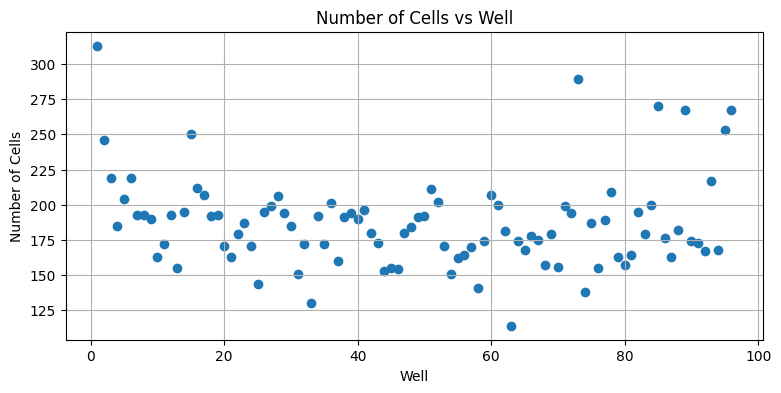

In [15]:
matplotlib.rcParams['figure.figsize'] = (9.0, 4.0)
fig = plt.figure()
plt.scatter(
    [int(value) for value in data.columns[0].values],
    [float(value) for value in data.columns[1].values])
plt.xlabel("Well")
plt.ylabel("Number of Cells")
plt.grid(True)
plt.title("Number of Cells vs Well")
plt.show()

### A little less simple plot: Heat Maps on a Plate Grid

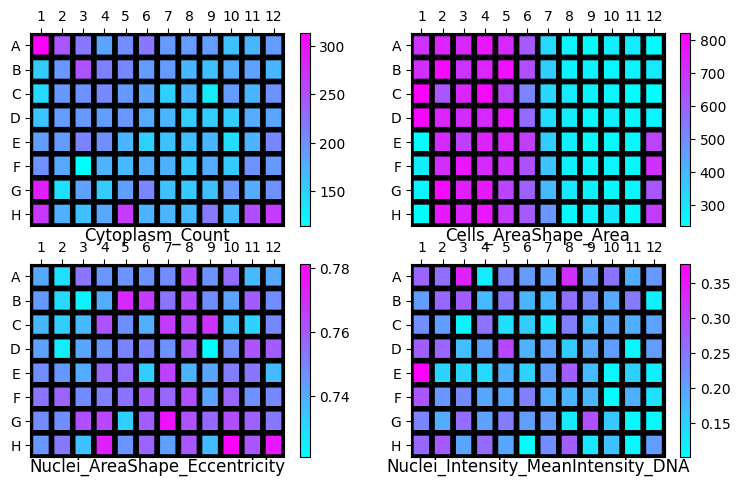

In [16]:
matplotlib.rcParams['figure.figsize'] = (9.0, 5.5)
# Create plate_layout object (Image ID to Row-Column map)
plate_id = input("Plate id: ")
plate_layout = gs_analytics.get_plate_layout(conn, plate_id)
# Read in columns from the OMERO.table
selected_column_names = [
    'Cytoplasm_Count',
    'Cells_AreaShape_Area',
    'Nuclei_AreaShape_Eccentricity',
    'Nuclei_Intensity_MeanIntensity_DNA',
    'Well']
selected_columns = [
    column_names.index(column_name) for
    column_name in selected_column_names]
data = omero_table.read(selected_columns, 0, number_of_rows)
display_matricies = []
# Display Heatmaps
fig = plt.figure()
for index in range(4):
    display_matrix = gs_analytics.build_display_matrix(
        plate_layout, data.columns[4].values, data.columns[index].values)
    ax = fig.add_subplot(2, 2, index + 1)
    im = ax.pcolor(display_matrix, cmap=cm.cool, edgecolors='k', linewidths=4)
    gs_analytics.set_axis_properties(ax)
    plt.title(selected_column_names[index], y=-0.12)
    plt.colorbar(im)
plt.show()

### Disconnect from the OMERO server

In [17]:
conn._closeSession()